<a href="https://colab.research.google.com/github/AiJared/job_matching_model/blob/main/job_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [2]:
# Mock data creation (you'll replace this with your actual data loading)
# This creates dummy data for development purposes
# In a real scenario, you'd load your candidates.csv, jobs.csv, and matches.csv

def create_mock_data():
    # Create candidate data
    candidates = pd.DataFrame({
        'id': range(1, 101),
        'skills': [
            'python java sql', 'javascript html css', 'c++ python', 'java spring hibernate',
            'react node.js mongodb', 'python django flask', 'java spring boot',
            'javascript react redux', 'python numpy pandas', 'c# .net sql'
        ] * 10,
        'experience': np.random.randint(0, 11, 100),
        'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 100),
        'location': np.random.choice(['New York', 'San Francisco', 'Seattle', 'Austin', 'Chicago'], 100)
    })

    # Create job data
    jobs = pd.DataFrame({
        'id': range(1, 51),
        'title': [
            'Software Engineer', 'Web Developer', 'Data Scientist', 'Backend Developer',
            'Frontend Developer', 'Full Stack Developer', 'DevOps Engineer',
            'ML Engineer', 'Data Analyst', 'Software Developer'
        ] * 5,
        'required_skills': [
            'python java sql', 'javascript html css', 'python pandas scikit-learn', 'java spring hibernate',
            'react javascript css', 'python django javascript', 'aws docker kubernetes',
            'python tensorflow keras', 'sql python tableau', 'c# .net sql'
        ] * 5,
        'min_experience': np.random.randint(0, 6, 50),
        'required_education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 50),
        'location': np.random.choice(['New York', 'San Francisco', 'Seattle', 'Austin', 'Chicago'], 50)
    })

    # Create match data (some good matches, some poor matches)
    matches = []
    for _ in range(300):
        candidate_id = np.random.randint(1, 101)
        job_id = np.random.randint(1, 51)

        # Simplistic match score calculation for demo
        candidate = candidates[candidates['id'] == candidate_id].iloc[0]
        job = jobs[jobs['id'] == job_id].iloc[0]

        # Basic matching logic - more sophisticated in real implementation
        skill_match = len(set(candidate['skills'].split()) & set(job['required_skills'].split())) / len(set(job['required_skills'].split()))
        exp_match = 1 if candidate['experience'] >= job['min_experience'] else 0.5
        edu_match = 1 if candidate['education'] == job['required_education'] else 0.7
        loc_match = 1 if candidate['location'] == job['location'] else 0.8

        match_score = (skill_match * 0.5 + exp_match * 0.3 + edu_match * 0.1 + loc_match * 0.1)

        matches.append({
            'candidate_id': candidate_id,
            'job_id': job_id,
            'match_score': match_score
        })

    matches_df = pd.DataFrame(matches)

    return candidates, jobs, matches_df

# Generate mock data
candidates_df, jobs_df, matches_df = create_mock_data()

# Display the first few rows of each dataframe
print("Candidates DataFrame:")
print(candidates_df.head())
print("\nJobs DataFrame:")
print(jobs_df.head())
print("\nMatches DataFrame:")
print(matches_df.head())

Candidates DataFrame:
   id                 skills  experience    education       location
0   1        python java sql           6     Bachelor        Seattle
1   2    javascript html css           4     Bachelor       New York
2   3             c++ python           3     Bachelor  San Francisco
3   4  java spring hibernate           6  High School        Chicago
4   5  react node.js mongodb           6          PhD       New York

Jobs DataFrame:
   id               title             required_skills  min_experience  \
0   1   Software Engineer             python java sql               2   
1   2       Web Developer         javascript html css               4   
2   3      Data Scientist  python pandas scikit-learn               4   
3   4   Backend Developer       java spring hibernate               5   
4   5  Frontend Developer        react javascript css               3   

  required_education       location  
0             Master         Austin  
1           Bachelor  San Franci

In [3]:
# Load actual data (uncomment and modify for your actual data)
"""
# Load your actual data
candidates_df = pd.read_csv('candidates.csv')
jobs_df = pd.read_csv('jobs.csv')
matches_df = pd.read_csv('matches.csv')

# Display basic statistics
print("Candidates DataFrame Info:")
print(candidates_df.info())
print("\nJobs DataFrame Info:")
print(jobs_df.info())
print("\nMatches DataFrame Info:")
print(matches_df.info())
"""

'\n# Load your actual data\ncandidates_df = pd.read_csv(\'candidates.csv\')\njobs_df = pd.read_csv(\'jobs.csv\')\nmatches_df = pd.read_csv(\'matches.csv\')\n\n# Display basic statistics\nprint("Candidates DataFrame Info:")\nprint(candidates_df.info())\nprint("\nJobs DataFrame Info:")\nprint(jobs_df.info())\nprint("\nMatches DataFrame Info:")\nprint(matches_df.info())\n'

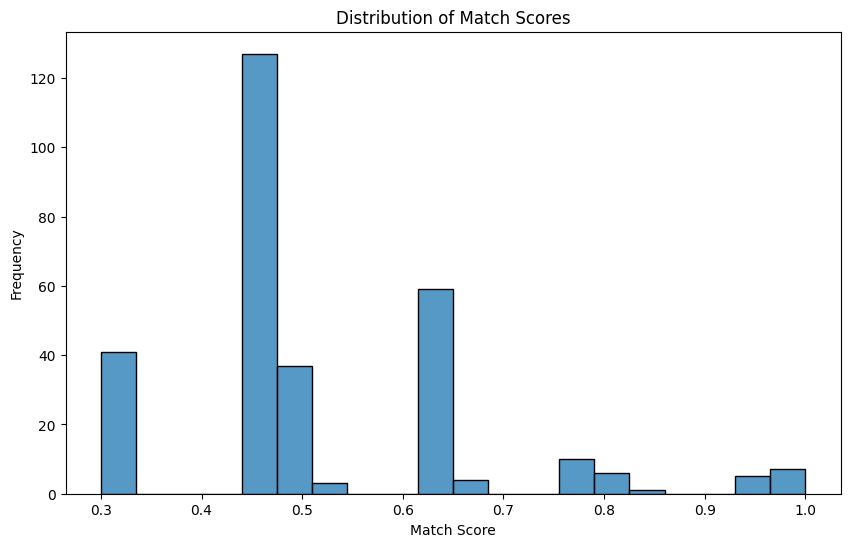

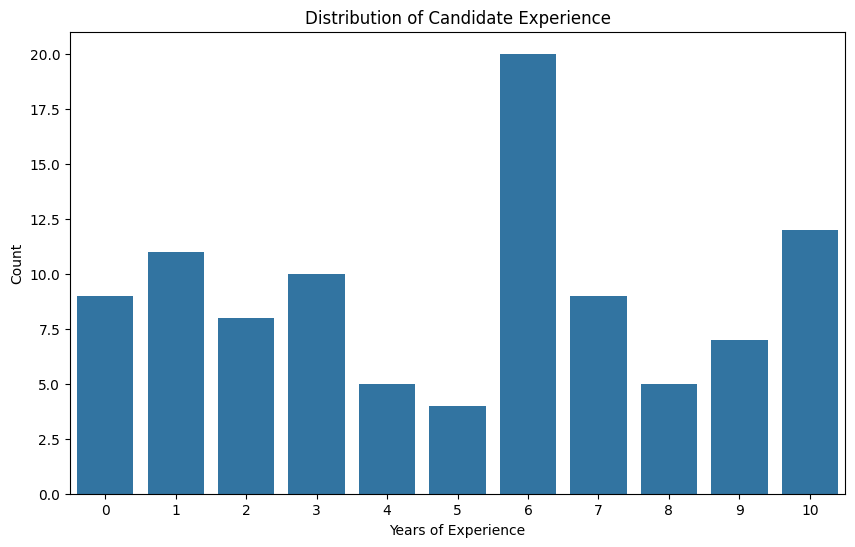

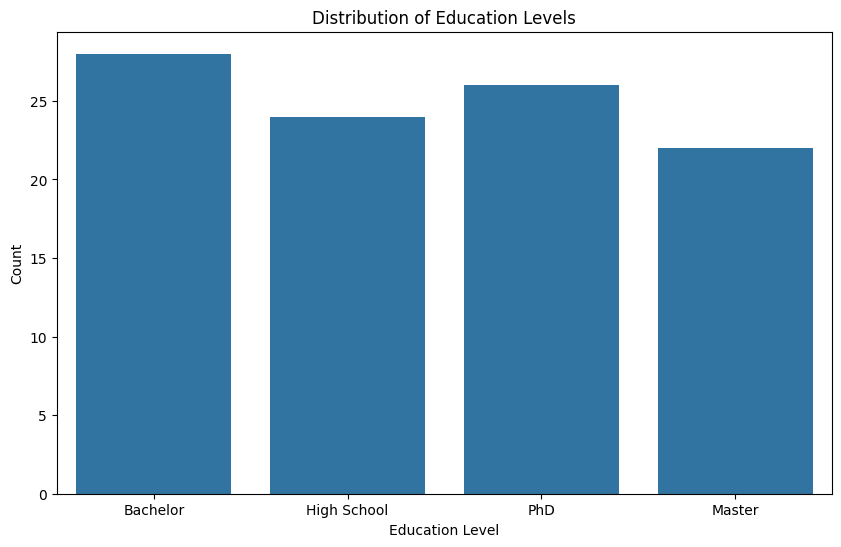

In [4]:
# Data Exploration and Visualization
# Explore the distribution of match scores
plt.figure(figsize=(10, 6))
sns.histplot(matches_df['match_score'], bins=20)
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.show()

# Explore candidate experience distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='experience', data=candidates_df)
plt.title('Distribution of Candidate Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Count')
plt.show()

# Explore education distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='education', data=candidates_df)
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()